# Weekly Training Progress Report

- Compares actual vs planned weekly distance, longest route, and training time.
- Calculates percentage of plan completed.
- Identifies trends (above/below plan) for distance.

- uses data from a database which log the actual training and compares it to the excel training plan

In [ ]:
import duckdb
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from datetime import datetime
from data.paths import DB_PATH, EXCEL_PATH


conn = duckdb.connect(DB_PATH)

### Database part

Fetch data from a database and calculate summaries

In [3]:
weekly_summary = conn.execute("""
    WITH weekly AS (
        SELECT
            strftime(activity_date, '%Y') AS year_id,
            strftime(activity_date, '%V') AS week_id,
            ROUND(SUM(EXTRACT(EPOCH FROM moving_time)) / 3600.0, 2) AS total_time_hours,
            DATE_TRUNC('second', AVG(avg_pace)) AS average_pace,
            SUM(distance_km) AS total_distance_km,
            MAX(distance_km) AS longest_hike,
            SUM(calories_kcal) AS total_calories,
            SUM(steps) AS total_steps,
            SUM(total_ascent) AS total_ascend_meters,
            SUM(total_descent) AS total_descent_meters,
            ROUND(AVG(min_temp_c),2) AS average_temperature,
            MIN(activity_date) AS week_start
        FROM tbl_activity
        WHERE EXTRACT(YEAR FROM activity_date) = EXTRACT(YEAR FROM CURRENT_DATE)
        GROUP BY year_id, week_id
        ORDER BY year_id, week_id DESC 
    )
    SELECT * FROM weekly;
             """).fetchdf()  # ← fetch as Pandas DataFrame

In [4]:
weekly_comparison = conn.execute("""
    WITH weekly AS (
        SELECT
            strftime(activity_date, '%Y')          AS year_id,
            strftime(activity_date, '%V')          AS week_id,
            MIN(activity_date)                     AS week_start,
            ROUND(SUM(EXTRACT(EPOCH FROM moving_time)) / 3600.0, 2) AS total_time_hours,
            -- convert pace to seconds for math
            AVG(EXTRACT(EPOCH FROM CAST(avg_pace AS INTERVAL))) AS average_pace_sec,
            SUM(distance_km)                AS total_distance_km,
            --SUM(calories_kcal)            AS total_calories,
            --SUM(steps)                    AS total_steps,
            --SUM(total_ascent)             AS total_ascend_meters,
            --SUM(total_descent)            AS total_descent_meters,
            --ROUND(AVG(min_temp_c), 2)     AS average_temperature
        FROM tbl_activity
        WHERE EXTRACT(YEAR FROM activity_date) = EXTRACT(YEAR FROM CURRENT_DATE)
        GROUP BY year_id, week_id
    )
    SELECT
        year_id,
        week_id,
        --week_start,
        total_distance_km,
        LAG(total_distance_km) OVER (ORDER BY week_start asc) AS prev_distance_km,
        ROUND(
        100.0 * ( total_distance_km - LAG(total_distance_km) OVER (ORDER BY week_start asc) )
                / NULLIF(LAG(total_distance_km) OVER (ORDER BY week_start asc), 0),
        1
        ) AS pct_change_distance,
        total_time_hours,
        LAG(total_time_hours) OVER (ORDER BY week_start asc) AS prev_time_hours,
        ROUND(
        100.0 * ( total_time_hours - LAG(total_time_hours) OVER (ORDER BY week_start asc) )
                / NULLIF(LAG(total_time_hours) OVER (ORDER BY week_start asc), 0),
        1
        ) AS pct_change_time,
        -- INTERVAL display for readability
        INTERVAL '1 second' * ROUND(average_pace_sec) AS average_pace,
        INTERVAL '1 second' * ROUND(LAG(average_pace_sec) OVER (ORDER BY week_start asc)) AS prev_average_pace,
        -- percent change still numeric
        ROUND(
        100.0 * ( LAG(average_pace_sec) OVER (ORDER BY week_start asc) - average_pace_sec )
                / NULLIF(LAG(average_pace_sec) OVER (ORDER BY week_start asc), 0),
        1
        ) AS pct_change_pace
    FROM weekly
    ORDER BY week_start DESC;
""").fetchdf()

### Excel part

Compare reality with a plan from excel.

But first connect excel and prepare columns into a dataframe.

In [ ]:
# Read the plan
plan_df = pd.read_excel(EXCEL_PATH, sheet_name="plán", parse_dates=["pondělí"], engine="openpyxl", usecols="A:H") 

for col in ["nejdelší trasa", "celkem týden", "doba v minutách", "doba v hodinách"]:
    plan_df[col] = plan_df[col].astype(str).str.replace(",", ".").astype(float)

plan_df['year_id_plan'] = plan_df['pondělí'].dt.year
plan_df = plan_df.dropna(subset=['year_id_plan'])

# Rename columns for convenience
plan_df = plan_df.rename(columns={
    "pondělí": "date",
    "týden roku": "week_id_plan",
    "tréninkový týden": "training_week",
    "nejdelší trasa": "longest_route_km_plan",
    "celkem týden": "total_distance_km_plan",
    "zbývá denně ujít": "remaining_daily_km",
    "doba v minutách": "time_min_plan",
    "doba v hodinách": "time_hours_plan"
})

# only to have a future plan shown (split into two so I can also compare past plans)
current_year = datetime.now().year
current_week = datetime.now().isocalendar().week

plan_future_df = plan_df[
    (plan_df['year_id_plan'] == current_year) &
    (plan_df['week_id_plan'] >= current_week)
].copy()

Ensure datatypes are correct and same for calculations - issues on year_id_plan = float + NaN (NaN dropped earlier)

In [6]:
# Ensure year_id is int in both DataFrames
plan_df['year_id_plan'] = plan_df['year_id_plan'].astype(int)
weekly_summary['year_id'] = weekly_summary['year_id'].astype(int)

# Also ensure week_id is int
plan_df['week_id_plan'] = plan_df['week_id_plan'].astype(int)
weekly_summary['week_id'] = weekly_summary['week_id'].astype(int)

Merge dataframes together to one for comparison and make some basic calculations.

In [7]:
comparison_df = pd.merge(
    weekly_summary,
    plan_df,
    left_on=['year_id', 'week_id'],
    right_on=['year_id_plan', 'week_id_plan'],  # your Excel column
    suffixes=('_actual', '_plan')
)

comparison_df = comparison_df[[
    "week_id","week_start",
    "total_distance_km", "total_distance_km_plan", 
    "longest_hike", "longest_route_km_plan",
    "total_time_hours", "time_hours_plan"
]]

# % of planned total distance
comparison_df['pct_distance'] = 100 * comparison_df['total_distance_km'] / comparison_df['total_distance_km_plan']

# % of planned longest hike
comparison_df['pct_longest_hike'] = 100 * comparison_df['longest_hike'] / comparison_df['longest_route_km_plan']

# % of planned time
comparison_df['pct_time'] = 100 * comparison_df['total_time_hours'] / comparison_df['time_hours_plan']

# trend based on distance
comparison_df['distance_trend'] = comparison_df['pct_distance'].apply(lambda x: 'above plan' if x >= 100 else 'below plan')

# Summaries and analyses

### Weekly summary
* shows only a summary of the week's progress.

In [8]:
weekly_summary.head()

,year_id,week_id,total_time_hours,average_pace,total_distance_km,longest_hike,total_calories,total_steps,total_ascend_meters,total_descent_meters,average_temperature,week_start
0,2025,44,1.75,0 days 00:12:49,8.79,7.15,392.0,12282.0,259.0,232.0,11.00,2025-10-29
1,2025,43,5.09,0 days 00:13:17,28.04,17.35,1283.0,34822.0,819.0,1152.0,10.00,2025-10-21
2,2025,42,0.97,0 days 00:08:13,7.12,7.12,388.0,8562.0,120.0,251.0,5.00,2025-10-19
3,2025,41,4.87,0 days 00:14:15,21.51,7.44,1034.0,29048.0,354.0,539.0,11.67,2025-10-09
4,2025,40,2.22,0 days 00:12:52,19.19,13.55,568.0,7742.0,222.0,250.0,8.00,2025-10-02


### Weekly summary comparison
* compares the actual past training between weeks to show trends and improvements or space for improvements.

In [9]:
weekly_comparison.head()

,year_id,week_id,total_distance_km,prev_distance_km,pct_change_distance,total_time_hours,prev_time_hours,pct_change_time,average_pace,prev_average_pace,pct_change_pace
0,2025,44,8.79,28.04,-68.7,1.75,5.09,-65.6,0 days 00:12:49,0 days 00:13:17,3.5
1,2025,43,28.04,7.12,293.8,5.09,0.97,424.7,0 days 00:13:17,0 days 00:08:13,-61.7
2,2025,42,7.12,21.51,-66.9,0.97,4.87,-80.1,0 days 00:08:13,0 days 00:14:16,42.4
3,2025,41,21.51,19.19,12.1,4.87,2.22,119.4,0 days 00:14:16,0 days 00:12:52,-10.8
4,2025,40,19.19,20.08,-4.4,2.22,4.38,-49.3,0 days 00:12:52,0 days 00:13:06,1.7


### Weekly plan
* what has been planned in training plan in excel for past and following weeks.

In [10]:
plan_future_df.head()


,date,week_id_plan,training_week,longest_route_km_plan,total_distance_km_plan,remaining_daily_km,time_min_plan,time_hours_plan,year_id_plan
1,2025-10-27,44.0,2,19.55,32.20,4.22,373.52,6.23,2025.0
2,2025-11-03,45.0,3,22.48,37.03,4.85,429.55,7.16,2025.0
3,2025-11-10,46.0,reg,15.74,25.92,3.39,493.98,8.23,2025.0
4,2025-11-17,47.0,5,25.85,42.58,5.58,568.08,9.47,2025.0
5,2025-11-24,48.0,6,29.73,48.97,6.41,653.29,10.89,2025.0


### Plan vs. reality
* comparison of a plan vs reality to see if I am adhering to the plan an/or by how much.

In [11]:
# show only key columns in a readable table
display(comparison_df[['week_id','week_start', 'total_distance_km', 'total_distance_km_plan',
                       'pct_distance', 'longest_hike', 'longest_route_km_plan',
                       'pct_longest_hike', 'total_time_hours', 'time_hours_plan', 'pct_time',
                       'distance_trend']].round(1))

,week_id,week_start,total_distance_km,total_distance_km_plan,pct_distance,longest_hike,longest_route_km_plan,pct_longest_hike,total_time_hours,time_hours_plan,pct_time,distance_trend
0,44,2025-10-29,8.8,32.2,27.3,7.2,19.6,36.6,1.8,6.2,28.1,below plan
1,43,2025-10-21,28.0,28.0,100.1,17.4,17.0,102.1,5.1,5.4,93.9,above plan


### Weekly distance
* a graph to show if I am adhering to a planned kilometers or not.

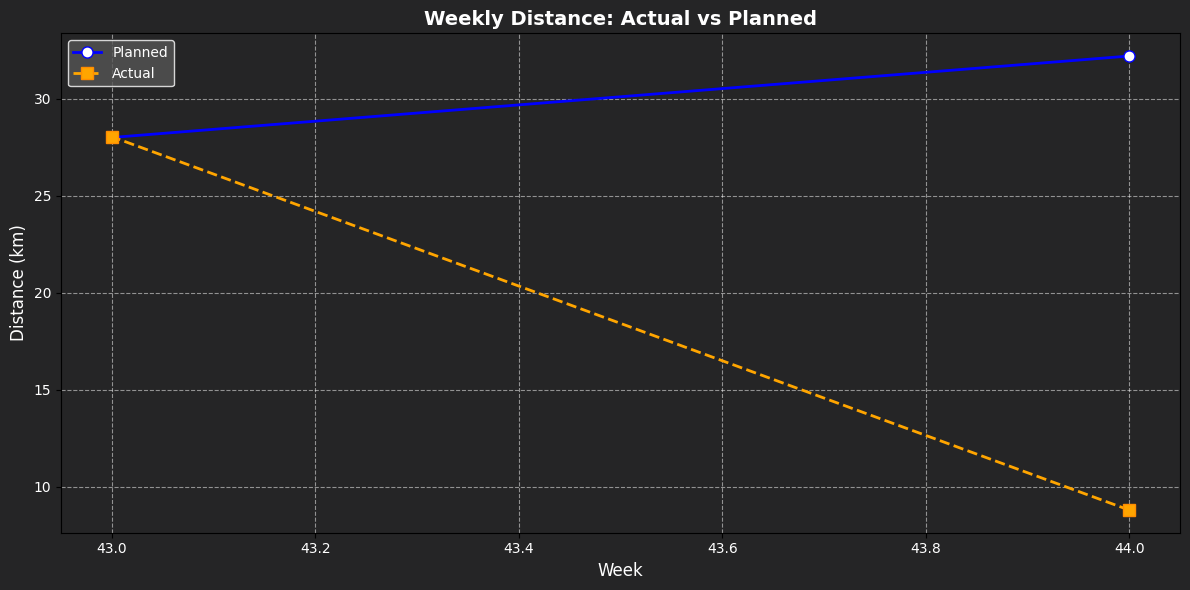

In [12]:
try:
    plt.figure(figsize=(12,6), facecolor="#252526")  # figure background

    weeks = comparison_df['week_id']

    plt.plot(weeks, comparison_df['total_distance_km_plan'],
            label='Planned',
            marker='o',
            markersize=8,
            markerfacecolor='white',
            markeredgecolor='blue',
            color='blue',
            linestyle='-',  # solid line
            linewidth=2)

    plt.plot(weeks, comparison_df['total_distance_km'],
            label='Actual',
            marker='s',
            markersize=8,
            markerfacecolor='orange',
            markeredgecolor='darkorange',
            color='orange',
            linestyle='--',  # dashed line
            linewidth=2)

    plt.xlabel('Week', fontsize=12, color='white')
    plt.ylabel('Distance (km)', fontsize=12, color='white')
    plt.title('Weekly Distance: Actual vs Planned', fontsize=14, weight='bold', color='white')
    plt.xticks(color='white')
    plt.yticks(color='white')
    plt.legend(facecolor='#555555', edgecolor='white', labelcolor='white')
    plt.grid(True, linestyle='--', alpha=0.5, color='white')

    # axes background color
    plt.gca().set_facecolor('#252526')

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Graph not possible to render due {e}")